# ST-590 Final Project
*Performed by: Muhammer Kurt, Nataliya Peshekhodko*

*08/01/2022*

## Introduction

The goals of this project are 
* Find a data set to explore and fit supervised learning models
* Conducting EDA through pandas-on-spark
* Fitting three different classes of models and choosing a best model

## Dataset

To achieve goals of this project Diabetic Data set from [Kaggle](https://www.kaggle.com/datasets/mathchi/diabetes-data-set) was chosen. This data set will be used to predict based on diagnostic measurements whether a patient has diabetes. We will build and fit classification models.

Variables in data set:
- *Pregnancies* - number of times pregnant
- *Glucose* - plasma glucose concentration a 2 hours in an oral glucose tolerance test
- *BloodPressure* - diastolic blood pressure (mm Hg)
- *SkinThickness* - triceps skin fold thickness (mm)
- *Insulin* - 2-Hour serum insulin (mu U/ml)
- *BMI* - body mass index (weight in kg/(height in m)^2)
- *DiabetesPedigreeFunction* - diabetes pedigree function
- *Age* - age (years)
- *Outcome* - class variable (0 or 1), 0 if patient is healthy, 1 if patient is diabetic.

## Data preparation

Import libraries and set up spark session.

In [1]:
# supress all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import os
import sys
import pyspark.pandas as ps
from pyspark.sql import SparkSession

from pyspark.ml.feature import SQLTransformer
from pyspark.ml.feature import VectorAssembler
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
spark = SparkSession.builder.getOrCreate()

Read data from `diabetics.csv` file.

In [2]:
data = pd.read_csv("data/diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Before split up data into train and test data sets we need to replace zero values for Blood pressure and Body mass index. These variables can't be equal to zero in real life.

In [3]:
print ("Number of 0 values for Diastolic Blood Pressure is "+ str(data[data.BloodPressure==0].BloodPressure.count()) +  
       "\nNumber of 0 values for Body Mass Index is " + str (data[data.BMI==0].BMI.count()))

Number of 0 values for Diastolic Blood Pressure is 35
Number of 0 values for Body Mass Index is 11


We will replace zero values for these variables with means for these variables (mean calculation will be adjusted not to include zero values).

In [4]:
data.BloodPressure.replace(0,data[data.BloodPressure!=0].BloodPressure.mean(),inplace=True)
data.BMI.replace (0, data[data.BMI!=0].BMI.mean(),inplace=True)

Convert pandas data frame into spark data frame.

In [5]:
diabetes = spark.createDataFrame(data)
diabetes.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|         72.0|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|         66.0|           29|      0|26.6|     0.35100000000000003| 31|      0|
|          8|    183|         64.0|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|         66.0|           23|     94|28.1|     0.16699999999999998| 21|      0|
|          0|    137|         40.0|           35|    168|43.1|      2.2880000000000003| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



Split up data set into training (80% of data) and testing (20% of data) data sets.

In [6]:
train, test = diabetes.randomSplit([0.8,0.2], seed = 1)
print(train.count(), test.count())

607 161


In [7]:
train.show(5)

+-----------+-------+-----------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|    BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-----------------+-------------+-------+----+------------------------+---+-------+
|          0|    100|             88.0|           60|    110|46.8|      0.9620000000000001| 31|      0|
|          0|    101|             65.0|           28|      0|24.6|                   0.237| 22|      0|
|          0|    105|             64.0|           41|    142|41.5|     0.17300000000000001| 22|      0|
|          0|    109|             88.0|           30|      0|32.5|                   0.855| 38|      1|
|          0|    131|72.40518417462484|            0|      0|43.2|                    0.27| 26|      1|
+-----------+-------+-----------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



## Exploratory data analysis

In this section we will conduct explanatory data analysis on training data set.

Let's start with describing all numeric feature variables (*splitting up into two tables for easy reading*) and count the outcome variable for each outcome. 

In [8]:
train.select('Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness' ).describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|       Pregnancies|           Glucose|     BloodPressure|     SkinThickness|
+-------+------------------+------------------+------------------+------------------+
|  count|               607|               607|               607|               607|
|   mean|3.7891268533772653|119.36738056013179| 72.65923480269974|20.191103789126853|
| stddev| 3.322840308863052|31.996263038169634|12.153251936684262|15.679958827932095|
|    min|                 0|                 0|              24.0|                 0|
|    max|                15|               199|             122.0|                63|
+-------+------------------+------------------+------------------+------------------+



In [9]:
train.select('Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age' ).describe().show()

+-------+-----------------+-----------------+------------------------+------------------+
|summary|          Insulin|              BMI|DiabetesPedigreeFunction|               Age|
+-------+-----------------+-----------------+------------------------+------------------+
|  count|              607|              607|                     607|               607|
|   mean| 75.0313014827018|32.50078193858964|      0.4653492586490939| 33.27347611202636|
| stddev|110.6757998930512| 6.96829781648047|     0.32853833196886145|11.871187278518361|
|    min|                0|             18.2|                   0.085|                21|
|    max|              846|             67.1|                    2.42|                81|
+-------+-----------------+-----------------+------------------------+------------------+



In [10]:
train.groupby('Outcome').count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      0|  401|
|      1|  206|
+-------+-----+



From the tables above it could be seen that there are zero min values for variables `Pregnancies`, `Glucose`, `SkinThickness` and `Insulin` which is acceptable. In the train data set we have almost twice more observations for healthy patients comparing with diabetics patients.

Check if there are any null values in the train data set.

In [11]:
import pyspark.sql.functions as f
# checking for null values in each column
data_agg = train.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in train.columns])
data_agg.show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



Now, let's look at min, mean and max values for each numeric feature variable in context of the outcome variable.

In [12]:
expl_vars = ['BloodPressure', 'Pregnancies', 'Glucose', 'SkinThickness', 'Insulin',
            'DiabetesPedigreeFunction', 'Age', 'BMI']

min_values = train.groupBy('Outcome').agg({var: 'min' for var in expl_vars})
min_values.show()

avg = train.groupBy('Outcome').agg({var: 'avg' for var in expl_vars[0:4]})
avg.show()
avg = train.groupBy('Outcome').agg({var: 'avg' for var in expl_vars[4:]})
avg.show()

max_values = train.groupBy('Outcome').agg({var: 'max' for var in expl_vars})
max_values.show()

+-------+----------------+------------+-----------------------------+------------------+--------+------------------+--------+------------+
|Outcome|min(Pregnancies)|min(Insulin)|min(DiabetesPedigreeFunction)|min(SkinThickness)|min(Age)|min(BloodPressure)|min(BMI)|min(Glucose)|
+-------+----------------+------------+-----------------------------+------------------+--------+------------------+--------+------------+
|      0|               0|           0|                        0.085|                 0|      21|              24.0|    18.2|           0|
|      1|               0|           0|          0.08800000000000001|                 0|      21|              30.0|    23.3|           0|
+-------+----------------+------------+-----------------------------+------------------+--------+------------------+--------+------------+

+-------+------------------+------------------+------------------+-----------------+
|Outcome|avg(BloodPressure)|      avg(Glucose)|avg(SkinThickness)| avg(Pregnanci

From the tables above it could be seen that 
- min values for the variables `BloodPressure` and `BMI` for healthy patients are different from mean values for diabetic patients
- average values for the variables `Glucose`, `Insulin` are significantly higher for diabetics patients comparing with healthy patients

Let's visualize distributions for each numeric variable in the context of the outcome variable.

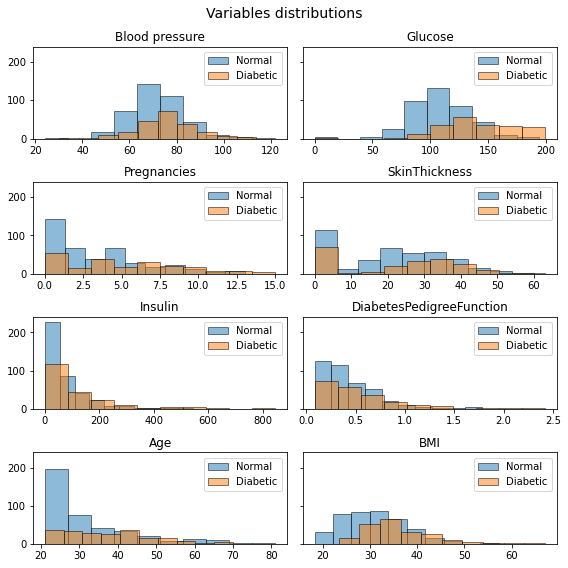

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
ps.options.plotting.backend = 'matplotlib'

eda_train = train.to_pandas_on_spark()

fig, axs = plt.subplots(4, 2, sharey=True, tight_layout=True, figsize = (8, 8))
fig.suptitle("Variables distributions", fontsize=14)
axs[0,0].hist(eda_train.loc[eda_train.Outcome == "0", ["BloodPressure"]].BloodPressure,  alpha = 0.5, ec="black", label="Normal")
axs[0,0].hist(eda_train.loc[eda_train.Outcome == "1", ["BloodPressure"]].BloodPressure,  alpha = 0.5, ec="black", label = "Diabetic")
axs[0,0].set_title("Blood pressure")
axs[0,0].legend()


axs[0,1].hist(eda_train.loc[eda_train.Outcome == "0", ["Glucose"]].Glucose,  alpha = 0.5, ec="black", label="Normal")
axs[0,1].hist(eda_train.loc[eda_train.Outcome == "1", ["Glucose"]].Glucose,  alpha = 0.5, ec="black", label = "Diabetic")
axs[0,1].set_title("Glucose")
axs[0,1].legend()

axs[1,0].hist(eda_train.loc[eda_train.Outcome == "0", ["Pregnancies"]].Pregnancies,  alpha = 0.5, ec="black", label="Normal")
axs[1,0].hist(eda_train.loc[eda_train.Outcome == "1", ["Pregnancies"]].Pregnancies,  alpha = 0.5, ec="black", label = "Diabetic")
axs[1,0].set_title("Pregnancies")
axs[1,0].legend()

axs[1,1].hist(eda_train.loc[eda_train.Outcome == "0", ["SkinThickness"]].SkinThickness,  alpha = 0.5, ec="black", label="Normal")
axs[1,1].hist(eda_train.loc[eda_train.Outcome == "1", ["SkinThickness"]].SkinThickness,  alpha = 0.5, ec="black", label = "Diabetic")
axs[1,1].set_title("SkinThickness")
axs[1,1].legend()

axs[2,0].hist(eda_train.loc[eda_train.Outcome == "0", ["Insulin"]].Insulin,  alpha = 0.5, ec="black", label="Normal")
axs[2,0].hist(eda_train.loc[eda_train.Outcome == "1", ["Insulin"]].Insulin,  alpha = 0.5, ec="black", label = "Diabetic")
axs[2,0].set_title("Insulin")
axs[2,0].legend()

axs[2,1].hist(eda_train.loc[eda_train.Outcome == "0", ["DiabetesPedigreeFunction"]].DiabetesPedigreeFunction,  alpha = 0.5, ec="black", label="Normal")
axs[2,1].hist(eda_train.loc[eda_train.Outcome == "1", ["DiabetesPedigreeFunction"]].DiabetesPedigreeFunction,  alpha = 0.5, ec="black", label = "Diabetic")
axs[2,1].set_title("DiabetesPedigreeFunction")
axs[2,1].legend()

axs[3,0].hist(eda_train.loc[eda_train.Outcome == "0", ["Age"]].Age,  alpha = 0.5, ec="black", label="Normal")
axs[3,0].hist(eda_train.loc[eda_train.Outcome == "1", ["Age"]].Age,  alpha = 0.5, ec="black", label = "Diabetic")
axs[3,0].set_title("Age")
axs[3,0].legend()

axs[3,1].hist(eda_train.loc[eda_train.Outcome == "0", ["BMI"]].BMI,  alpha = 0.5, ec="black", label="Normal")
axs[3,1].hist(eda_train.loc[eda_train.Outcome == "1", ["BMI"]].BMI,  alpha = 0.5, ec="black", label = "Diabetic")
axs[3,1].set_title("BMI")
axs[3,1].legend()

From the histograms above it could be seen that distributions of `Blood pressure`, `Glucose`, `Insulin`, `Age` and `BMI` might be different for each outcome. 

We will at box plots for these variables next.

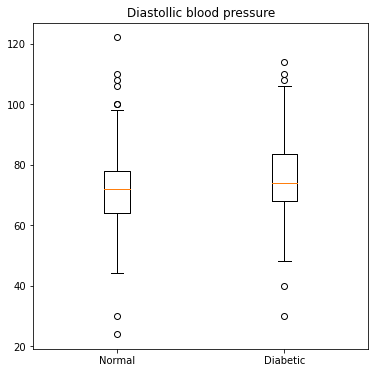

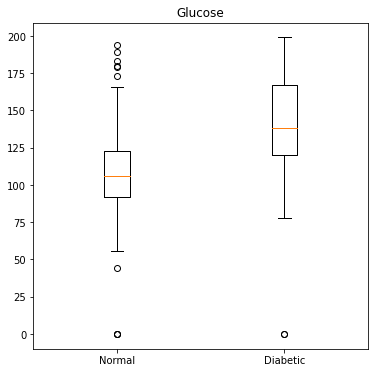

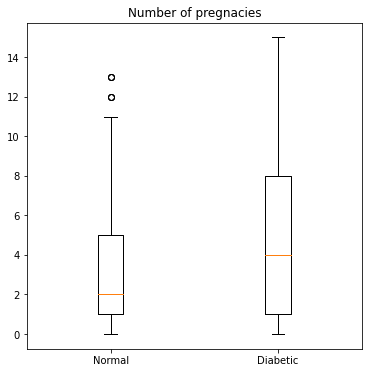

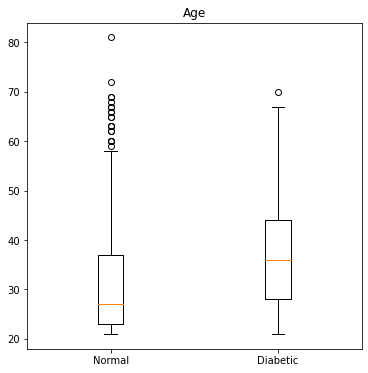

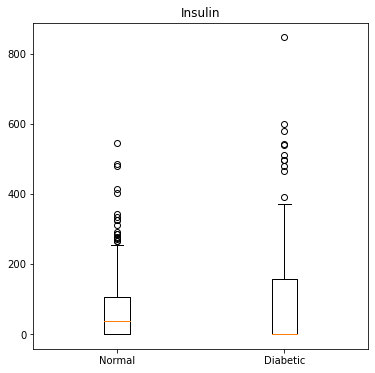

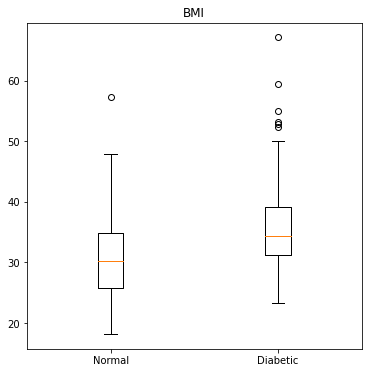

In [14]:
plt.rcParams['figure.figsize'] = [6, 6]
a = eda_train.loc[eda_train['Outcome'] == 0, 'BloodPressure']
b = eda_train.loc[eda_train['Outcome'] == 1, 'BloodPressure']
data = [a,b]
for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])
plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('Diastollic blood pressure')
plt.show()

a = eda_train.loc[eda_train['Outcome'] == 0, 'Glucose']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Glucose']
data = [a,b]
for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])
plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('Glucose')
plt.show()

a = eda_train.loc[eda_train['Outcome'] == 0, 'Pregnancies']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Pregnancies']
data = [a,b]
for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])
plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('Number of pregnacies')
plt.show()

a = eda_train.loc[eda_train['Outcome'] == 0, 'Age']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Age']
data = [a,b]
for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])
plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('Age')
plt.show()

a = eda_train.loc[eda_train['Outcome'] == 0, 'Insulin']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Insulin']
data = [a,b]
for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])
plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('Insulin')
plt.show()

a = eda_train.loc[eda_train['Outcome'] == 0, 'BMI']
b = eda_train.loc[eda_train['Outcome'] == 1, 'BMI']
data = [a,b]
for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])
plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('BMI')
plt.show()

From the graphs above it could be concluded that medians for `Age`, `Pregnacies`, `Glucose` and `BMI` are higher for diabetics patients comparing with healthy patients. Median for `blood pressure` is slightly higher for diabetic patients comparing with healthy patients.  Median for `Insulin` is lower (and completely equal to zero) for diabetic patients comparing with healthy patients.  

Now, let's see if there are correlations between feature numeric variables.

In [15]:
eda_train[['BloodPressure', 'Pregnancies', 'Glucose', 'SkinThickness', 'Insulin','DiabetesPedigreeFunction', 'Age', 'BMI']].corr()

,BloodPressure,Pregnancies,Glucose,SkinThickness,Insulin,DiabetesPedigreeFunction,Age,BMI
BloodPressure,1.000000,0.189019,0.230920,0.007712,-0.054817,-0.011798,0.335703,0.242875
Pregnancies,0.189019,1.000000,0.125612,-0.096489,-0.061967,-0.066191,0.540907,-0.009001
Glucose,0.230920,0.125612,1.000000,0.045829,0.295180,0.107185,0.261922,0.224549
SkinThickness,0.007712,-0.096489,0.045829,1.000000,0.449423,0.176543,-0.128871,0.375401
Insulin,-0.054817,-0.061967,0.295180,0.449423,1.000000,0.137497,-0.017874,0.157282
DiabetesPedigreeFunction,-0.011798,-0.066191,0.107185,0.176543,0.137497,1.000000,0.022669,0.154629
Age,0.335703,0.540907,0.261922,-0.128871,-0.017874,0.022669,1.000000,0.006848
BMI,0.242875,-0.009001,0.224549,0.375401,0.157282,0.154629,0.006848,1.000000


There are no significant correlation between numeric variables in the data set.

Let's look at relationship between some numeric variables in context of outcome variable.

<AxesSubplot:title={'center':'Age vs insulin'}, xlabel='Age', ylabel='Insulin'>

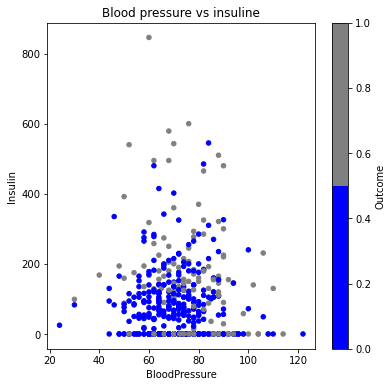

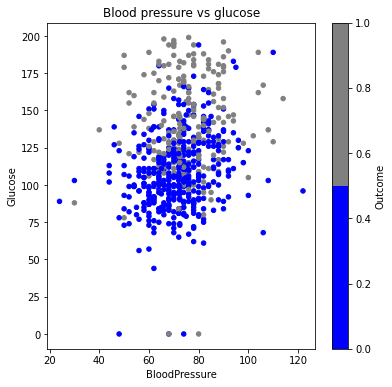

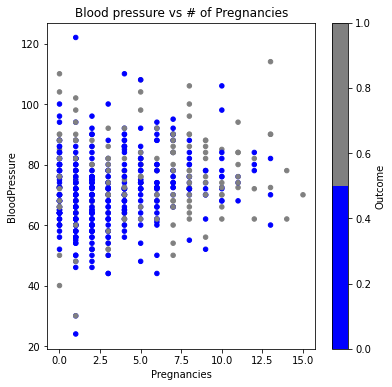

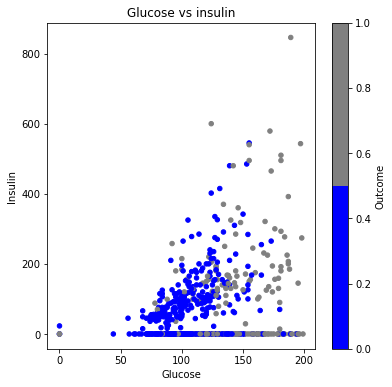

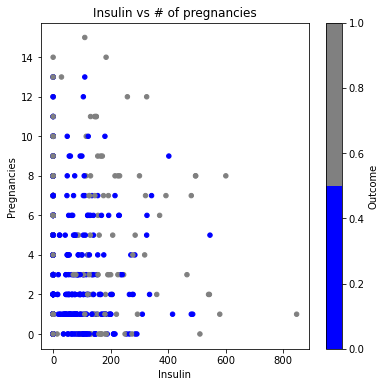

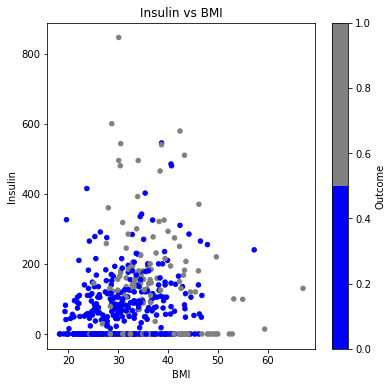

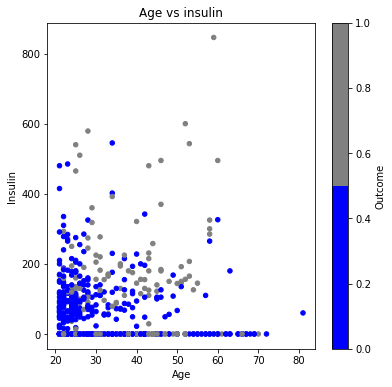

In [16]:
mycmap = colors.ListedColormap(['blue', 'grey'])

eda_train.plot.scatter(x='BloodPressure', y='Insulin', c = 'Outcome', colormap = mycmap, 
                       ylabel = "Insulin level", 
                       xlabel = "Blood pressure",
                       title = "Blood pressure vs insuline",
                       sharex = False,
                       figsize = (6, 6))

eda_train.plot.scatter(x='BloodPressure', y='Glucose', c = 'Outcome', colormap = mycmap,
                       ylabel = "Glucose", 
                       xlabel = "Blood pressure",
                       title = "Blood pressure vs glucose",
                       sharex = False,
                       figsize = (6, 6))

eda_train.plot.scatter(x='Pregnancies', y='BloodPressure', c = 'Outcome', colormap = mycmap,
                       ylabel = "BloodPressure", 
                       xlabel = "# of Pregnancies",
                       title = "Blood pressure vs # of Pregnancies",
                       sharex = False,
                       figsize = (6, 6))

eda_train.plot.scatter(x='Glucose', y='Insulin', c = 'Outcome', colormap = mycmap, 
                       ylabel = "Insulin", 
                       xlabel = "Glucose",
                       title = "Glucose vs insulin",
                       sharex = False,
                       figsize = (6, 6))
eda_train.plot.scatter(x='Insulin', y='Pregnancies', c = 'Outcome', colormap = mycmap, 
                       ylabel = "# of pregnancies", 
                       xlabel = "Insulin",
                       title = "Insulin vs # of pregnancies",
                       sharex = False,
                       figsize = (6, 6))
eda_train.plot.scatter(x='BMI', y='Insulin', c = 'Outcome', colormap = mycmap,
                       ylabel = "Insulin", 
                       xlabel = "BMI",
                       title = "Insulin vs BMI",
                       sharex = False,
                       figsize = (6, 6))
eda_train.plot.scatter(x='Age', y='Insulin', c = 'Outcome', colormap = mycmap,
                       ylabel = "Insulin", 
                       xlabel = "Age",
                       title = "Age vs insulin",
                       sharex = False,
                       figsize = (6, 6))

From the graphs above it could be concluded that there is no significant difference in interaction between `insulin` and `blood pressure`, `blood pressure` and `pregnancies`, `insulin` and `pregancies`, `insulin` and `BMI`, `Age` and `Insulin` for each type of outcome. However, there are could be difference in interaction for `blood pressure` and `glucose`, `glucose` and `insulin` for each type of outcome. It make sense to consider such interactions in the model.

## Modeling 

Three different classes of models will be fitted.

### Model 1

First model will be fitted with `Glucose`, `Insulin`, `Pregancies`, `BMI` and log of `Age`. Polynomial second degree transformation will be applied to all variables. Spark pipeline will be used to set up all transformations for train and test data sets.

Import pyspark machine learning libraries, create object of logistic regression class and set up variable selection and transformation.

In [17]:
from pyspark.ml.feature import SQLTransformer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression()

sqlTrans = SQLTransformer(
    statement = "SELECT log(Age) as Age, Glucose, \
    Insulin, Pregnancies, BMI, \
    outcome as label FROM __THIS__")

With `VectorAssemler` assemble all selected columns to single column.

In [18]:
assembler = VectorAssembler(inputCols = ["Age", "Glucose", "Insulin", "Pregnancies", "BMI"], 
                            outputCol = "features_for", handleInvalid = 'keep')

Apply second degree polynomial transformation to assembled column.

In [19]:
px = PolynomialExpansion(degree=2, inputCol="features_for", outputCol="features")

Set up pipeline with 4 stages.

In [20]:
pipeline = Pipeline(stages = [sqlTrans, assembler, px, lr])

We will use cross-validation to find best model with default performance metric `areaUnderROC`. Create parameter grid for cross validation.

In [21]:
paramGrid = (ParamGridBuilder()
             #.addGrid(lr.regParam, [0, 0.01, 0.1, 0.5, 1.0, 2.0]) \
             .addGrid(lr.regParam, [0, 0.5, 1.0, 2.0]) \
             .addGrid(lr.fitIntercept, [False, True]) \
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
             #.addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
             #.addGrid(lr.maxIter, [1, 5, 10, 20, 50]) \
             .build())

Create 5 folds cross validator.

In [22]:
crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

Retrieve default metric used by `BinaryClassificationEvaluator`.

In [23]:
BinaryClassificationEvaluator().getMetricName()

'areaUnderROC'

`AUC - ROC` curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. The Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.

Fitting the best model for the whole train data set.

In [24]:
cvModel = crossval.fit(train)

Let's look at coefficients for best model

In [25]:
print(cvModel.bestModel.stages[3]._java_obj.intercept(), cvModel.bestModel.stages[3]._java_obj.coefficients())

-4.811204917768331 [0.16299405918340953,0.02018816522849583,0.004584678167323876,0.0010763417622121798,2.0685992512985457E-5,4.9665265311910475E-5,3.929602096856716E-5,1.813761243629557E-6,5.065280630572629E-7,0.011892486250468499,0.002921082641213298,1.4286411639848496E-4,5.342433599382249E-5,0.001299848656513907,0.014966050631708375,0.004438828938038403,1.067928504279098E-4,1.6115934896429882E-6,5.318089012899083E-4,1.9080898835217454E-4]


Now, let's plot ROC curve. The ROC curve will be plotted with TPR (True Positive Rate) against the FPR(False Positive Rate) where TPR is on the y-axis and FPR is on the x-axis.

**TPR = True Positives/(True Positives + False Negatives)**

**FPR = False Positives/(True Negatives + False Positives)**

Area under this curve is the performance metric we measure for our model. An excellent model has Area Under the Curve (AUC) near to the 1 which means it has a good measure of separability. A poor model has an AUC near 0 which means it has the worst measure of separability.

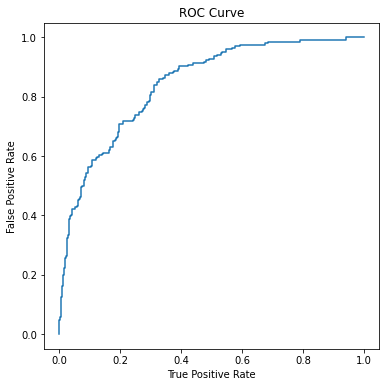

In [26]:
model_t= cvModel.bestModel.stages[3] 
trainingSummary = model_t.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Let's looks at Precision vs Recall for derived model. 

Precision is a metric that quantifies the number of correct positive predictions made.

**Precision = True Positives / (True Positives + False Positives)**

Recall is another name used for TPR. Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.

**Recall = True Positives / (True Positives + False Negatives)**


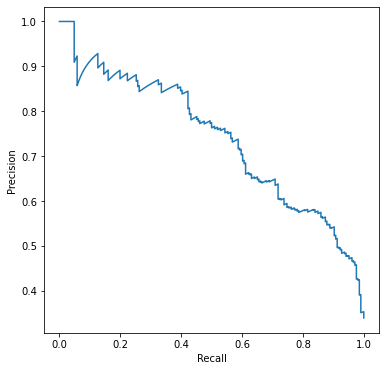

In [27]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

Predict outcome on test data set and show 5 first records.

In [28]:
cvModel.transform(test).show(5)

+------------------+-------+-------+-----------+----+-----+--------------------+--------------------+--------------------+--------------------+----------+
|               Age|Glucose|Insulin|Pregnancies| BMI|label|        features_for|            features|       rawPrediction|         probability|prediction|
+------------------+-------+-------+-----------+----+-----+--------------------+--------------------+--------------------+--------------------+----------+
|3.4339872044851463|    118|    230|          0|45.8|    1|[3.43398720448514...|[3.43398720448514...|[0.25182641975884...|[0.56262599386828...|       0.0|
|3.4339872044851463|     85|      0|          1|26.6|    0|[3.43398720448514...|[3.43398720448514...|[1.93055707378459...|[0.87331106669793...|       0.0|
| 3.044522437723423|     89|     94|          1|28.1|    0|[3.04452243772342...|[3.04452243772342...|[1.95167826667780...|[0.87562952443043...|       0.0|
|3.2188758248682006|     95|     38|          1|19.6|    0|[3.21887582

Evaluate derived predictions

In [29]:
predictions = cvModel.transform(test)
metric = BinaryClassificationEvaluator().evaluate(predictions)
print("areaUnderROC = " + str(metric) )

areaUnderROC = 0.7706093189964158


Now, we will derive and visualize confusion matrix

In [30]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_true = predictions.select("label")
y_true = y_true.toPandas()
y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix_non_norm = confusion_matrix(y_true, y_pred)
cnf_matrix_norm=confusion_matrix (y_true, y_pred, normalize='true')

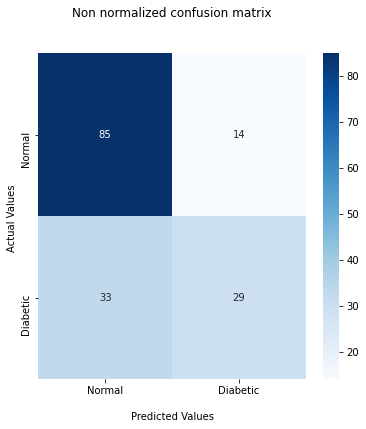

In [31]:
import seaborn as sns

ax = sns.heatmap(cnf_matrix_non_norm, annot=True, cmap='Blues')
ax.set_title('Non normalized confusion matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Normal','Diabetic'])
ax.yaxis.set_ticklabels(['Normal','Diabetic'])
plt.show()

From the matrix above we can see that model correctly classify as normal 85 patients and 29 patients as diabetic. However, model misclassify 14 normal patients as diabetic and 33 diabetic patients as normal.

Let's normalize these metrics to better understand model performance.

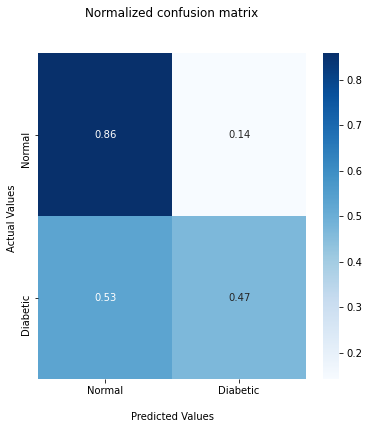

In [32]:
ax = sns.heatmap(cnf_matrix_norm, annot=True, cmap='Blues')
ax.set_title('Normalized confusion matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Normal','Diabetic'])
ax.yaxis.set_ticklabels(['Normal','Diabetic'])
plt.show()

Obtained model correctly predicted 86% of healthy patients and correctly predicted 47% of diabetic patients.

### Model 2

Second model will be fitted with all numerical variables in the data set and `log` transformation will be applied to `BloodPressure` and `Age`variables. 

By analogy with the first model, set up transformation, vector assembler and pipeline with three stages.

In [33]:
sqlTrans = SQLTransformer(
    statement = "SELECT log(Age) as Age, log(BloodPressure) as BloodPressure, \
    Pregnancies, Glucose, SkinThickness, \
    Insulin, DiabetesPedigreeFunction, BMI, \
    outcome as label FROM __THIS__"
)

assembler = VectorAssembler(inputCols = ["Age", "BloodPressure", 
                                         "Pregnancies", "Glucose", 
                                         "SkinThickness", "Insulin", 
                                         "DiabetesPedigreeFunction", 
                                         "BMI"], 
                            outputCol = "features", handleInvalid = 'keep')

pipeline = Pipeline(stages = [sqlTrans, assembler, lr])

As it was done before, we use cross-validation to find best model with default performance metric `areaUnderROC`. Create parameter grid for cross validation.

In [34]:
paramGrid = (ParamGridBuilder()
             #.addGrid(lr.regParam, [0, 0.01, 0.1, 0.5, 1.0, 2.0]) \
             .addGrid(lr.regParam, [0, 0.5, 1.0, 2.0]) \
             .addGrid(lr.fitIntercept, [False, True]) \
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
             #.addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
             #.addGrid(lr.maxIter, [1, 5, 10, 20, 50]) \
             .build())

Create 5 folds cross validator.

In [35]:
crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

Fitting the best model for the whole train data set.

In [36]:
cvModel = crossval.fit(train)

Checking regression coefficients for the best model

In [37]:
print(cvModel.bestModel.stages[2]._java_obj.intercept(), cvModel.bestModel.stages[2]._java_obj.coefficients())

-8.600768721417856 [0.7670123185709343,-0.8838059211993827,0.1209244330702258,0.035883725245747,-0.007987407132017935,-1.9049421599068363E-4,0.7827355619193521,0.11797231057322713]


Now, let's plot ROC curve for derived model.

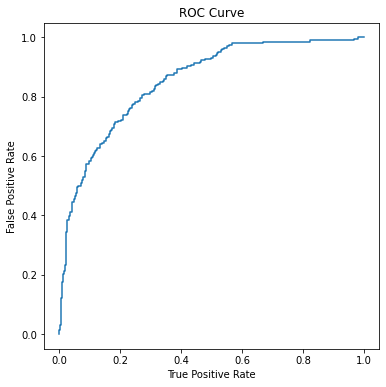

In [38]:
model2= cvModel.bestModel.stages[2]
trainingSummary = model2.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The target area under the ROC curve is as close as possible to one. We can roughly estimate area from graph and conclude that we are missing somewhere around 20% of the area.

Let's look at Precision vs Recall curve.

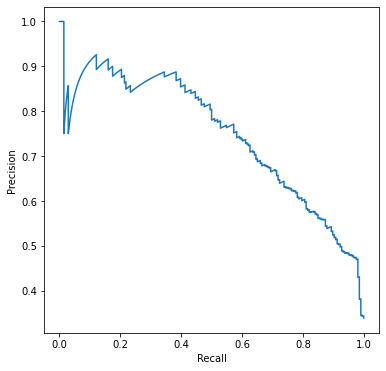

In [39]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Precision recall curve is less smooth for this model comparing with first model. Our goal is to maximize area under this curve.

Run obtained model against test data set and predict outcomes.

In [40]:
cvModel.transform(test).show(5)

+------------------+-----------------+-----------+-------+-------------+-------+------------------------+----+-----+--------------------+--------------------+--------------------+----------+
|               Age|    BloodPressure|Pregnancies|Glucose|SkinThickness|Insulin|DiabetesPedigreeFunction| BMI|label|            features|       rawPrediction|         probability|prediction|
+------------------+-----------------+-----------+-------+-------------+-------+------------------------+----+-----+--------------------+--------------------+--------------------+----------+
|3.4339872044851463|4.430816798843313|          0|    118|           47|    230|                   0.551|45.8|    1|[3.43398720448514...|[0.23336346334338...|[0.55807753676093...|       0.0|
|3.4339872044851463|4.189654742026425|          1|     85|           29|      0|     0.35100000000000003|26.6|    0|[3.43398720448514...|[3.31748998693507...|[0.96502397054851...|       0.0|
| 3.044522437723423|4.189654742026425|       

Obtain performance metric which is `areaUnderROC`

In [41]:
predictions = cvModel.transform(test)

metric = BinaryClassificationEvaluator().evaluate(predictions)
print(metric)

0.7896709025741284


Now let's create and visualize confusion matrix.

In [42]:
y_true = predictions.select("label")
y_true = y_true.toPandas()
y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix_non_norm = confusion_matrix(y_true, y_pred)
cnf_matrix_norm=confusion_matrix (y_true, y_pred, normalize='true')

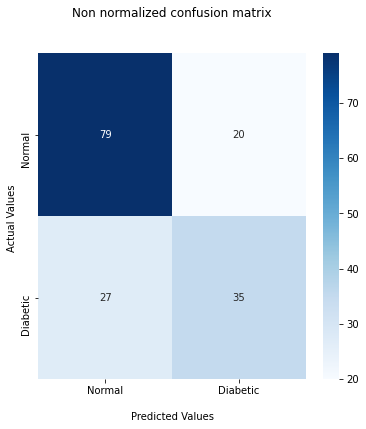

In [43]:
ax = sns.heatmap(cnf_matrix_non_norm, annot=True, cmap='Blues')
ax.set_title('Non normalized confusion matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Normal','Diabetic'])
ax.yaxis.set_ticklabels(['Normal','Diabetic'])
plt.show()

From the matrix above we can see that model correctly classify as normal 79 patients and 35 patients as diabetic. However, model misclassify 20 normal patients as diabetic and 35 diabetic patients as normal from the test data set.

Let's normalize these metrics to better understand model performance.

Plot non-normalized confusion matrix

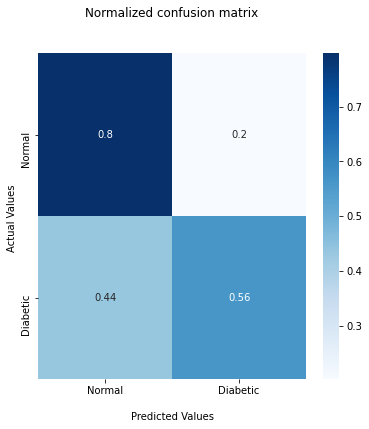

In [44]:
ax = sns.heatmap(cnf_matrix_norm, annot=True, cmap='Blues')
ax.set_title('Normalized confusion matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Normal','Diabetic'])
ax.yaxis.set_ticklabels(['Normal','Diabetic'])
plt.show()

Second model correctly predicted 80% of healthy patients and 56% of diabetic patients for test data set. Model misclassify 20% of normal as diabetic and 44% diabetic as normal for the test datat set.

### Model 3

Third model will be fitted using all numeric variables and interactions terms between `BloodPressure`, `Glucose`, `SkinThickness` and `Insulin`. Spark pipeline will be used to set up all transformations for train and test data sets.

Let's set up transformation, interaction, vector assembler and pipeline with four stages.

In [45]:
from pyspark.ml.feature import Interaction

sqlTrans = SQLTransformer(
    statement = "SELECT Age, BloodPressure, \
    Pregnancies, Glucose, SkinThickness, \
    Insulin, DiabetesPedigreeFunction, BMI, \
    outcome as label FROM __THIS__"
)
                            
interaction = Interaction(inputCols=["BloodPressure", "Glucose", "SkinThickness", 
                                     "Insulin"], outputCol="interactedCol")

assembler = VectorAssembler(inputCols = ["Age", "BloodPressure", 
                                         "Pregnancies", "Glucose", 
                                         "SkinThickness", "Insulin",  
                                         "DiabetesPedigreeFunction", "BMI", 
                                         "interactedCol"], 
                            outputCol = "features", handleInvalid = 'keep')

pipeline = Pipeline(stages = [sqlTrans, interaction, assembler, lr])

Create parameter grid for cross validation.

In [46]:
paramGrid = (ParamGridBuilder()
             #.addGrid(lr.regParam, [0, 0.01, 0.1, 0.5, 1.0, 2.0]) \
             .addGrid(lr.regParam, [0, 0.5, 1.0, 2.0]) \
             .addGrid(lr.fitIntercept, [False, True]) \
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
             #.addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
             #.addGrid(lr.maxIter, [1, 5, 10, 20, 50]) \
             .build())

Create 5 folds cross validator.

In [47]:
crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

Fitting the best model for the whole train data set.

In [48]:
cvModel = crossval.fit(train)

Checking coefficients for the best model

In [49]:
print(cvModel.bestModel.stages[3]._java_obj.intercept(), cvModel.bestModel.stages[3]._java_obj.coefficients())

-9.319668807020648 [0.011073391572677636,-0.011870591135610007,0.13973397245751065,0.036257080913293015,-0.008704125567015287,-6.862941149001097E-4,0.7999467068677496,0.11770605380203311,1.3911742696058928E-9]


Let's build ROC curve for the model.

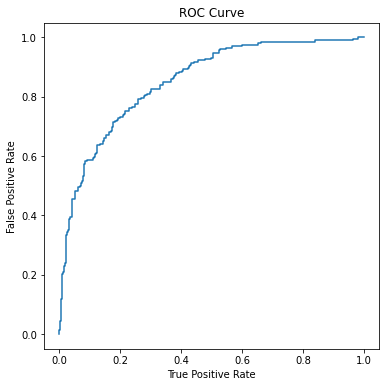

In [50]:
model3= cvModel.bestModel.stages[3]
trainingSummary = model3.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Rough visual estimation of the area under the ROC curve show that model missing approximately 20% from area eqaul to 1.

Now, let's plot precision vs recall plot.

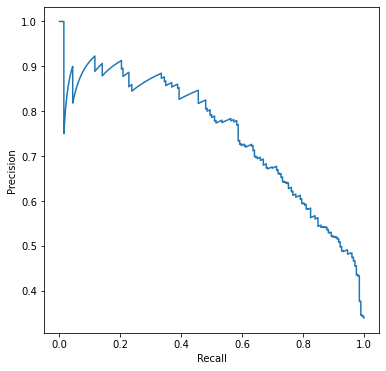

In [51]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Our goal is to maximize area under this curve for precision/recall curve.

Run obtained model against test data set and predict outcomes.

In [52]:
cvModel.transform(test).show(5)

+---+-------------+-----------+-------+-------------+-------+------------------------+----+-----+-------------+--------------------+--------------------+--------------------+----------+
|Age|BloodPressure|Pregnancies|Glucose|SkinThickness|Insulin|DiabetesPedigreeFunction| BMI|label|interactedCol|            features|       rawPrediction|         probability|prediction|
+---+-------------+-----------+-------+-------------+-------+------------------------+----+-----+-------------+--------------------+--------------------+--------------------+----------+
| 31|         84.0|          0|    118|           47|    230|                   0.551|45.8|    1|[1.0714872E8]|[31.0,84.0,0.0,11...|[0.28135888206459...|[0.56987934044891...|       0.0|
| 31|         66.0|          1|     85|           29|      0|     0.35100000000000003|26.6|    0|        [0.0]|[31.0,66.0,1.0,85...|[3.37892414932926...|[0.96703933047893...|       0.0|
| 21|         66.0|          1|     89|           23|     94|     0.16

Obtain performance metric which is `areaUnderROC`

In [53]:
predictions = cvModel.transform(test)
metric = BinaryClassificationEvaluator().evaluate(predictions)
print(metric)

0.7849462365591398


Obtain and display non-normalized confusion matrix

In [54]:
y_true = predictions.select("label")
y_true = y_true.toPandas()
y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix_non_norm = confusion_matrix(y_true, y_pred)
cnf_matrix_norm=confusion_matrix (y_true, y_pred, normalize='true')

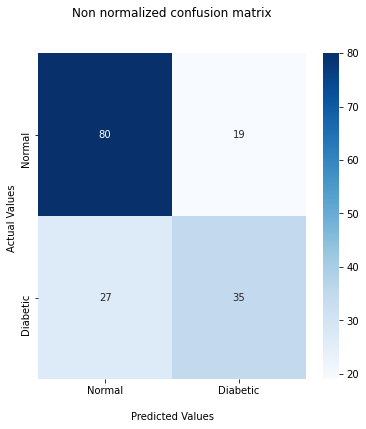

In [55]:
ax = sns.heatmap(cnf_matrix_non_norm, annot=True, cmap='Blues')
ax.set_title('Non normalized confusion matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Normal','Diabetic'])
ax.yaxis.set_ticklabels(['Normal','Diabetic'])
plt.show()

From the matrix above we can see that model correctly classified as normal 80 patients and 35 patients as diabetic. However, model misclassify 19 normal patients as diabetic and 35 diabetic patients as normal from the test data set.

Let's normalize these metrics to better understand model performance.

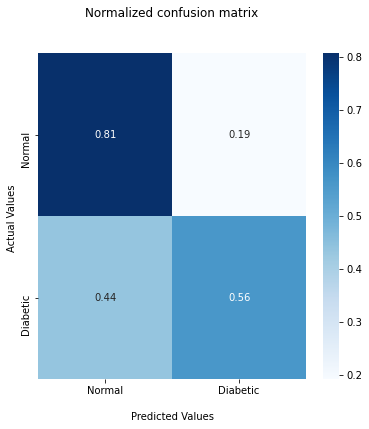

In [56]:
ax = sns.heatmap(cnf_matrix_norm, annot=True, cmap='Blues')
ax.set_title('Normalized confusion matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Normal','Diabetic'])
ax.yaxis.set_ticklabels(['Normal','Diabetic'])
plt.show()

For test data set model correctly predicted 81% of healthy patients and 56% of diabetic patients. Model misclassified 19% of normal as diabetic and 44% diabetic as normal for the test data set.

## Summary